# Mercari price suggestion challenge

Mercari is an online selling app which is powered by one of the biggest communities of Japan where users can sell their used multiple category of products. It is similar to Quikr in India. The community wants to offer the price suggestion to sellers so that they will be able to know what the price or value of the product is before they sell it.

This is not an easy task because the sellers are allowed to put any category of products or any bundle of things on the app, and the price of the product depends on many factors like brand name, usage of the product, condition of the product, how old the product is, etc. It is quite common to get different prices for the same product of different brands and different item conditions.

Sellers will have to upload the product information like product name, description, brand, category, item condition, shipping information (whether shipping charge will be given by seller or buyer).

The Mercari community wants to build a machine learning model that should be able to suggest the right price of the product to the seller depending upon the above attributes provided by the seller. The goal of this task is to build a regression model that will suggest the price of the product depending upon the attributes of the product given. 

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import pickle
import joblib
from scipy import sparse

In [ ]:
pip install pyunpack

In [ ]:
pip install patool

     |████████████████████████████████| 77 kB 3.9 MB/s 


In [ ]:
!pip install -q kaggle

## Loading data from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pratikpophali","key":"c325a56d4ba16ab693e0ec9ee2049035"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c mercari-price-suggestion-challenge

 87% 65.0M/74.3M [00:00<00:00, 64.9MB/s]
100% 74.3M/74.3M [00:00<00:00, 89.9MB/s]
100% 293M/294M [00:03<00:00, 73.0MB/s]
100% 294M/294M [00:03<00:00, 98.8MB/s]
 64% 5.00M/7.77M [00:00<00:00, 46.1MB/s]
100% 7.77M/7.77M [00:00<00:00, 49.3MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 173MB/s]
 79% 27.0M/34.0M [00:00<00:00, 39.4MB/s]
100% 34.0M/34.0M [00:00<00:00, 74.8MB/s]


In [ ]:
from pyunpack import Archive
Archive('/content/train.tsv.7z').extractall("/content")

In [ ]:
!unzip test_stg2.tsv.zip

Archive:  test_stg2.tsv.zip
  inflating: test_stg2.tsv           


In [ ]:
train_data = pd.read_csv("/content/train.tsv", sep='\t')
test_data = pd.read_csv("/content/test_stg2.tsv", sep='\t')

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1482535, 8)
(3460725, 7)


In [ ]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Handling missing value features

In [ ]:
train_data.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [ ]:
test_data.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name           False
shipping             False
item_description     False
dtype: bool

In [ ]:
train_data['category_name'].fillna('missing/missing/missing', inplace=True)
test_data['category_name'].fillna('missing/missing/missing', inplace=True)

In [ ]:
train_data['brand_name'].fillna('missing', inplace=True)
test_data['brand_name'].fillna('missing', inplace=True)

In [ ]:
train_data['item_description'].fillna('No description yet', inplace=True)
test_data['item_description'].fillna('No description yet', inplace=True)

In [ ]:
train_data.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
dtype: bool

## Splitting categories

In [ ]:
train_data['cat_1'] = train_data['category_name'].apply(lambda x : x.split('/')[0].strip())
train_data['cat_2'] = train_data['category_name'].apply(lambda x : x.split('/')[1].strip())
train_data['cat_3'] = train_data['category_name'].apply(lambda x : x.split('/')[2].strip())

In [ ]:
test_data['cat_1'] = test_data['category_name'].apply(lambda x : x.split('/')[0].strip())
test_data['cat_2'] = test_data['category_name'].apply(lambda x : x.split('/')[1].strip())
test_data['cat_3'] = test_data['category_name'].apply(lambda x : x.split('/')[2].strip())

In [ ]:
train_data.drop('category_name', axis=1, inplace=True)
test_data.drop('category_name', axis=1, inplace=True)

Printing head of train_data

In [ ]:
train_data.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


Removing data with invalid price

In [ ]:
train_data = train_data[train_data['price']>0]

In [ ]:
train_data.shape

(1481661, 10)

## Searching missing values of brand names in item name and item description.

In [ ]:
train_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/train_data.pkl')

In [ ]:
train_data['brand_name_mod'] = train_data['brand_name']

In [ ]:
brand_set = set(train_data['brand_name_mod'].values)
len(brand_set)

4808

In [ ]:
for i in tqdm(range(len(train_data))):
  
  if train_data.iloc[i]['brand_name_mod'] == 'missing':
    a = train_data.iloc[i]['name'].split()
    b = train_data.iloc[i]['item_description'].split()
    c = set(a+b)
    for j in c:
      if j in brand_set:
        d = train_data.iloc[i]['train_id']
        train_data.loc[d, 'brand_name_mod'] = j


100%|██████████| 1481661/1481661 [1:35:32<00:00, 258.47it/s]


In [ ]:
by_brand = train_data.groupby('brand_name_mod')

In [ ]:
by_brand_mean = by_brand.mean()

In [ ]:
by_brand_mean['price']

brand_name_mod
!iT Jeans           16.000000
% Pure              16.344262
10.Deep             17.333333
191 Unlimited       36.000000
1byone              45.000000
                      ...    
tokidoki            33.205556
totes ISOTONER      16.642857
triangl swimwear    44.600000
vineyard vines      24.881940
wallis               8.000000
Name: price, Length: 4808, dtype: float64

In [ ]:
for i in range(0, 125, 25):
  a = 0
  a = by_brand_mean['price'].quantile(i/100)
  print('{} th percetile is {}'.format(i, a))

0 th percetile is 3.0
25 th percetile is 14.0
50 th percetile is 19.0
75 th percetile is 28.321138211382113
100 th percetile is 413.25


## Creating feature as a pricing category cheap, affordable and expensive based on the percentile value

In [ ]:
def costing(x):
  """
  A function for definig pricing category.
  If the price is less than 25th perc, then 'cheap',
  if the price is between 25th perc. and 75th perc, then 'afforadable',
  if the price is above 75t perc. then 'expensive.
  
  """
  if x < 14:
    y = 'cheap'
  elif x > 14 and x < 28.3:
    y = 'affordable'
  else:
    y = 'expensive'
  
  return y

In [ ]:
by_brand_mean.head()

,train_id,item_condition_id,price,shipping,medain_brand_price
brand_name_mod,,,,,
!iT Jeans,8.163520e+05,2.000000,16.000000,0.000000,16.0
% Pure,7.781490e+05,1.311475,16.344262,0.557377,14.0
10.Deep,8.984763e+05,2.666667,17.333333,0.000000,16.0
191 Unlimited,1.445400e+06,3.000000,36.000000,0.000000,36.0
1byone,1.248342e+06,1.000000,45.000000,0.000000,45.0


In [ ]:
by_brand_mean['pricing_cat'] = by_brand_mean['price'].apply(costing)

In [ ]:
by_brand_mean.head()

,train_id,item_condition_id,price,shipping,medain_brand_price,pricing_cat
brand_name_mod,,,,,,
!iT Jeans,8.163520e+05,2.000000,16.000000,0.000000,16.0,affordable
% Pure,7.781490e+05,1.311475,16.344262,0.557377,14.0,affordable
10.Deep,8.984763e+05,2.666667,17.333333,0.000000,16.0,affordable
191 Unlimited,1.445400e+06,3.000000,36.000000,0.000000,36.0,expensive
1byone,1.248342e+06,1.000000,45.000000,0.000000,45.0,expensive


In [ ]:
brand_price = dict(zip(by_brand_mean.index, by_brand_mean.pricing_cat))

In [ ]:
a_file = open("/content/drive/MyDrive/Colab Notebooks/Case_study_1/brand_price.pkl", "wb")
pickle.dump(brand_price, a_file)
a_file.close()

In [ ]:
a_file = open("/content/drive/MyDrive/Colab Notebooks/Case_study_1/brand_price.pkl", "rb")
output = pickle.load(a_file)

In [ ]:
def dict_fun(x):
  """
  A function for specifying a pricing category based on the brand name and mean brand price
  
  """
  if x in brand_price.keys():
    return brand_price[x]
  else:
    return 'affordable'

In [ ]:
train_data['pricing_cat'] = train_data['brand_name_mod'].apply(dict_fun)

In [ ]:
train_data['brand_name'] = train_data['brand_name_mod']

In [ ]:
train_data.drop('brand_name_mod', axis=1, inplace=True)
train_data.head()

## Creating feature as median of price for brand_name

In [ ]:
by_brand = train_data.groupby('brand_name')

In [ ]:
by_brand_median = by_brand.median()
by_brand_median.head()

,train_id,item_condition_id,price,shipping,medain_brand_price
brand_name,,,,,
!iT Jeans,816352.0,2.0,16.0,0.0,16.0
% Pure,837320.0,1.0,14.0,1.0,14.0
10.Deep,1125972.0,3.0,16.0,0.0,16.0
191 Unlimited,1445400.0,3.0,36.0,0.0,36.0
1byone,1248341.5,1.0,45.0,0.0,45.0


In [ ]:
brand_price_median = dict(zip(by_brand_median.index, by_brand_median.price))

In [ ]:
a_file = open("/content/drive/MyDrive/Colab Notebooks/Case_study_1/brand_price_median.pkl", "wb")
pickle.dump(brand_price_median, a_file)
a_file.close()

In [ ]:
a_file = open("/content/drive/MyDrive/Colab Notebooks/Case_study_1/brand_price_median.pkl", "rb")
output = pickle.load(a_file)

In [ ]:
brand_price_median = output

In [ ]:
def dict_fun2(x):
  """
  A function for calculating median brand price feature based on brand name
  
  """
  if x in brand_price_median.keys():
    return brand_price_median[x]
  else:
    return brand_price_median['missing']

In [ ]:
train_data['medain_brand_price'] = train_data['brand_name'].apply(dict_fun2)

In [ ]:
train_data.to_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/train_data.pkl')

In [ ]:
train_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/train_data.pkl')

In [ ]:
train_data.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,pricing_cat,medain_brand_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,MLB,10.0,1,No description yet,Men,Tops,T-shirts,affordable,10.0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,expensive,37.5
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,affordable,12.0
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,affordable,14.0
4,4,24K GOLD plated rose,1,Complete,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,affordable,19.0


# Exploratory data analysis (EDA)

## Price

In [ ]:
train_data['price'].describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

It is seen from the above information that the mean price in the data is only 26.753, whereas the maximum priceis very huge i.e 2009/- which indiacates that the distribution is highly skewed.

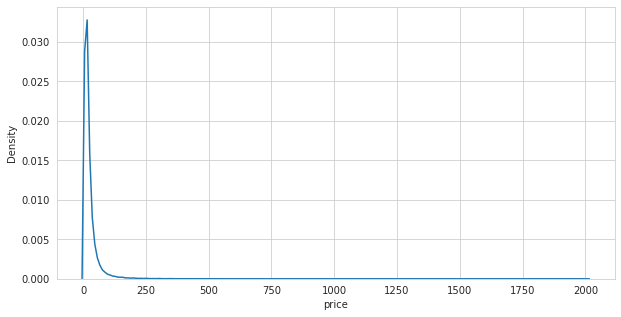

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.kdeplot(train_data['price'])
plt.show()

From the above plot of disribution, it is very clear that the maximum number of examples have the price less than or equal to 50, whereas very few examples have price in the range of 50 to 2000. It indicates that the distribution is highly skewed. Thus, there there are very less chances of errors on low price exaples and very high chances of getting errors on high price exaamples. Hence scaling of the target variable might be neccessary. (eg. log(price))

In [ ]:
for i in range(0, 110, 10):
  a = 0
  a = train_data['price'].quantile(i/100)
  print('{} th percetile is {}'.format(i, a))

0 th percetile is 3.0
10 th percetile is 7.0
20 th percetile is 10.0
30 th percetile is 12.0
40 th percetile is 14.0
50 th percetile is 17.0
60 th percetile is 20.0
70 th percetile is 26.0
80 th percetile is 34.0
90 th percetile is 51.0
100 th percetile is 2009.0


The same information can be obtained from the percentile values also. 90 % of examples have price less than or equal to 51.

## Item comdition ID

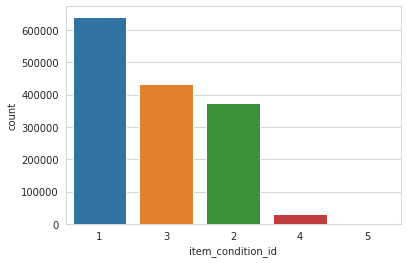

In [ ]:
sns.countplot(x='item_condition_id', data=train_data, order = train_data['item_condition_id'].value_counts().index)

The above figure indicates that highest no. of examples are from item condition id of1 followed by id 3, the lowest no of items are for item condition id 5.

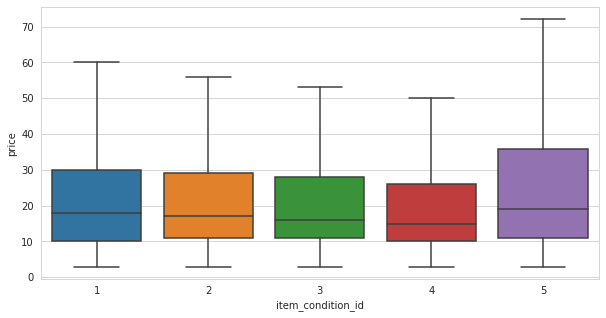

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.boxplot(x='item_condition_id', y='price', data=train_data, showfliers=False)
plt.show()

The above figure indicates the inter quantile range of price of different item condition ids examples and it can be seen that for all item condition ids, the range is almost similar only the id 5 has somewhat higher range.

In [ ]:
df = train_data.groupby('item_condition_id').mean().reset_index()

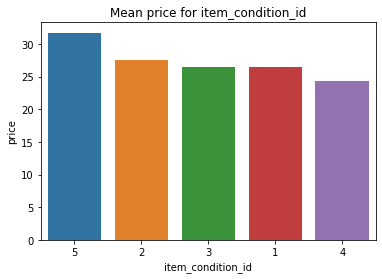

In [ ]:
sns.barplot(x='item_condition_id', y='price', data=df, order=df.sort_values('price', ascending=False).item_condition_id)
plt.title('Mean price for item_condition_id')
plt.show()

Fig. shows the mean price of examples for all item condition ids, the maximum mean price is for item condition id 5 and least is for id 4.

## Brand name

In [ ]:
train_data['brand_name'].describe()

count     1481661
unique       4808
top       missing
freq       419897
Name: brand_name, dtype: object

<BarContainer object of 15 artists>

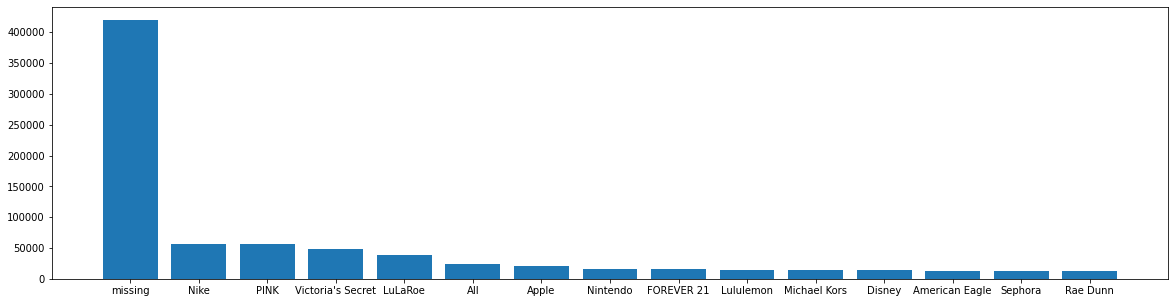

In [ ]:
brand_count = Counter(list(train_data.brand_name.values))
x, y = zip(*brand_count.most_common(15))
plt.figure(figsize=(20, 5))
plt.bar(x, y)

Selecting top 15 brands based on their counts and plotting their no of counts. It is seen that the brand name is missing for the highest no of examples. PINK, Nike, and Victoria's secret are top 3 brands of which no of examples are highest.

In [ ]:
x_lst = list(x)

In [ ]:
train_data_mod = train_data[train_data['brand_name'].isin(x_lst)]
train_data_mod.shape

(777105, 12)

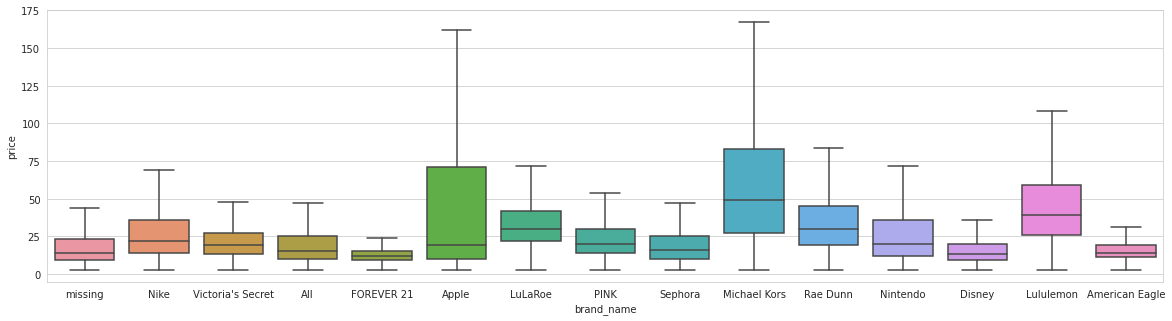

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 5))
sns.boxplot(x='brand_name', y='price', data=train_data_mod, showfliers=False)
plt.show()

Fig shows the inter quantile range range of price for top 15 brand names. It can be seen that for almost all brands the range fall in the same interval, only Apple and Michael Kors have somewhat high range.

In [ ]:
df = train_data_mod.groupby('brand_name').mean().reset_index()

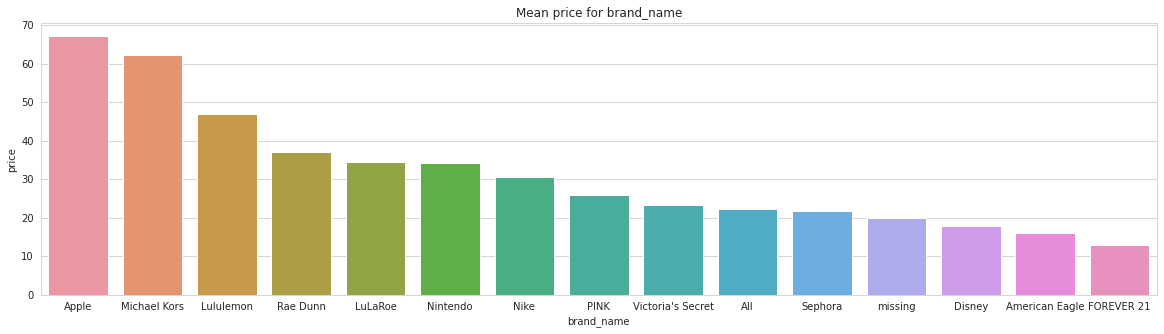

In [ ]:
plt.figure(figsize=(20, 5))
sns.barplot(x='brand_name', y='price', data=df, order=df.sort_values('price', ascending=False).brand_name)
plt.title('Mean price for brand_name')
plt.show()

Fig shows the mean price of examples of top 15 brand names. Apple and Michael Kors have the highest two mean price of the other brands.

## Shipping

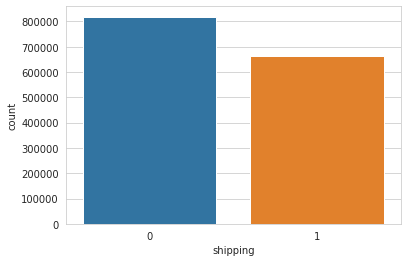

In [ ]:
sns.countplot(x='shipping', data=train_data)

Fig shows the no of examples based on the shipping category, means whether the shipping charge is given be seller or buyer. It is seen that the no of examples with shipping category zero are somewhat higher than shipping category one.

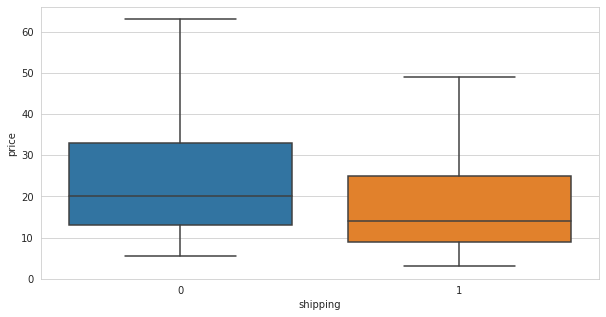

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.boxplot(x='shipping', y='price', data=train_data, showfliers=False)
plt.show()

The inter quantile range of examples with shipping category 0 is somewhat higher than with that of shipping category 1.

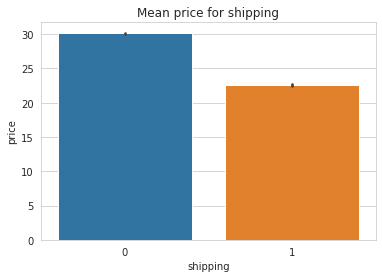

In [ ]:
sns.barplot(x='shipping', y='price', data=train_data)
plt.title('Mean price for shipping')
plt.show()

The mean price for examples with shipping category zero is higher than that of shipping category one.

## Category_1

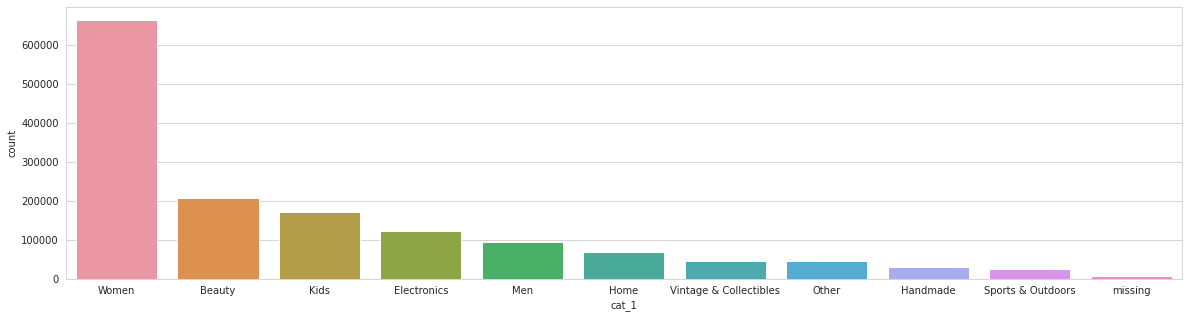

In [ ]:
plt.figure(figsize=(20, 5))
sns.countplot(x='cat_1', data=train_data, order = train_data['cat_1'].value_counts().index)

It is clear from the above fig that the highest no of examples are from Women category, followed by beuty and kids. The no of examples from Men category are failry less. It indicates that the dataset contains large no of products related to Womens.

In [ ]:
df = train_data.groupby('cat_1').mean().reset_index()

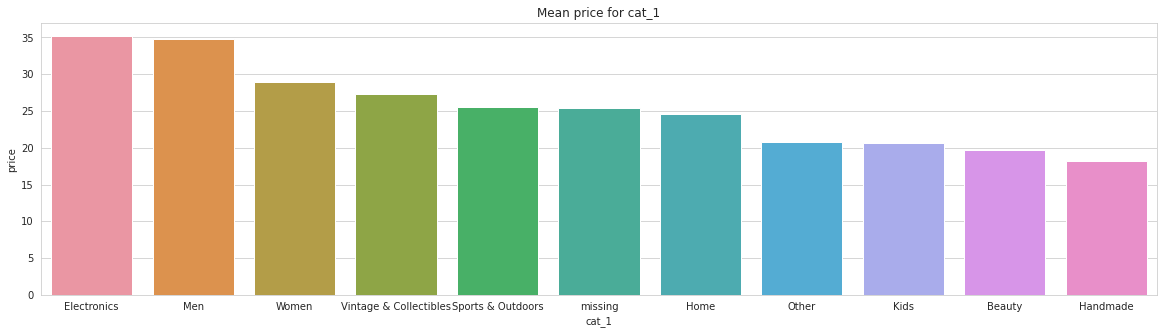

In [ ]:
plt.figure(figsize=(20, 5))
sns.barplot(x='cat_1', y='price', data=df, order=df.sort_values('price', ascending=False).cat_1)
plt.title('Mean price for cat_1')
plt.show()

Fig shows the higest mean price is for Electronics products the lowest is for handmade products which is logical.

## Category_2

<BarContainer object of 15 artists>

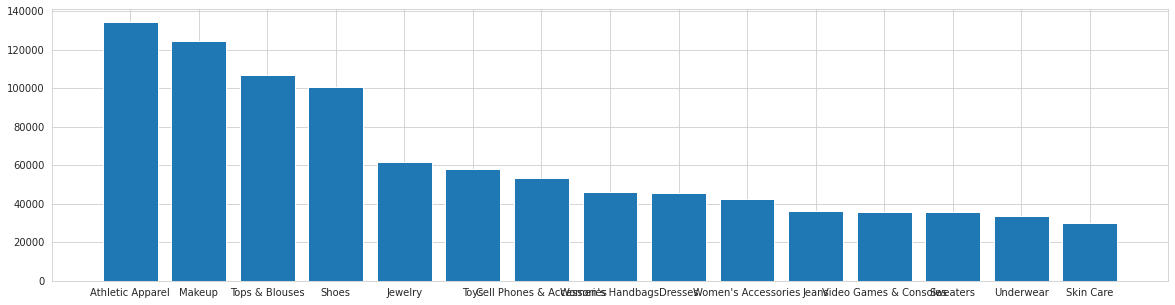

In [ ]:
cat_2_count = Counter(list(train_data['cat_2'].values))
x, y = zip(*cat_2_count.most_common(15))
plt.figure(figsize=(20, 5))
plt.bar(x, y)

Top 15 cat_2 examples have been taken and their count plot is plotted. It is seen that the highest no of examples is of Athletic type followed by Makeup, Tops and Bouses. 

In [ ]:
x_lst = list(x)

In [ ]:
train_data_mod = train_data[train_data['cat_2'].isin(x_lst)]
train_data_mod.shape

(944529, 11)

In [ ]:
df = train_data_mod.groupby('cat_2').mean().reset_index()

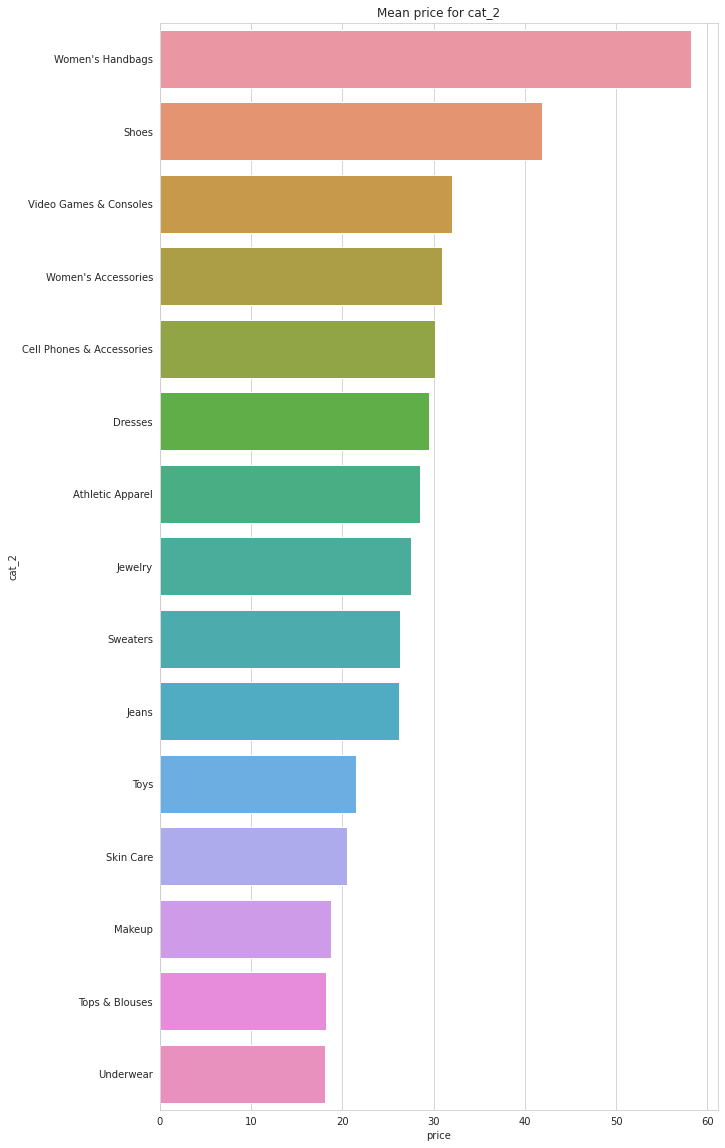

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(y='cat_2', x='price', data=df, order=df.sort_values('price', ascending=False).cat_2)
plt.title('Mean price for cat_2')
plt.show()

It can be seen that the highest price is for Women's handbag category followed by shoes and Women's accesories.

## Category_3

<BarContainer object of 15 artists>

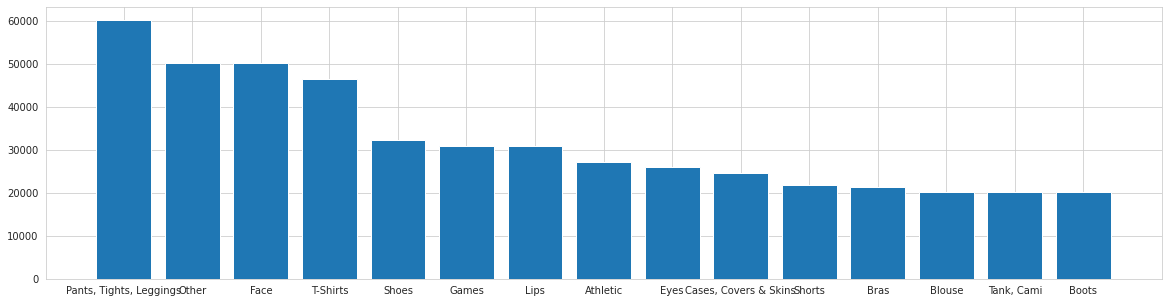

In [ ]:
cat_3_count = Counter(list(train_data['cat_3'].values))
x, y = zip(*cat_3_count.most_common(15))
plt.figure(figsize=(20, 5))
plt.bar(x, y)

Top 15 cat_3 examples based on their counts have been taken and their count plot is plotted. It is seen that highest no of examples are of Pants, tights, followed by others and face items and T-shits.

In [ ]:
x_lst = list(x)

In [ ]:
train_data_mod = train_data[train_data['cat_3'].isin(x_lst)]
train_data_mod.shape

(482323, 11)

In [ ]:
df = train_data_mod.groupby('cat_3').mean().reset_index()

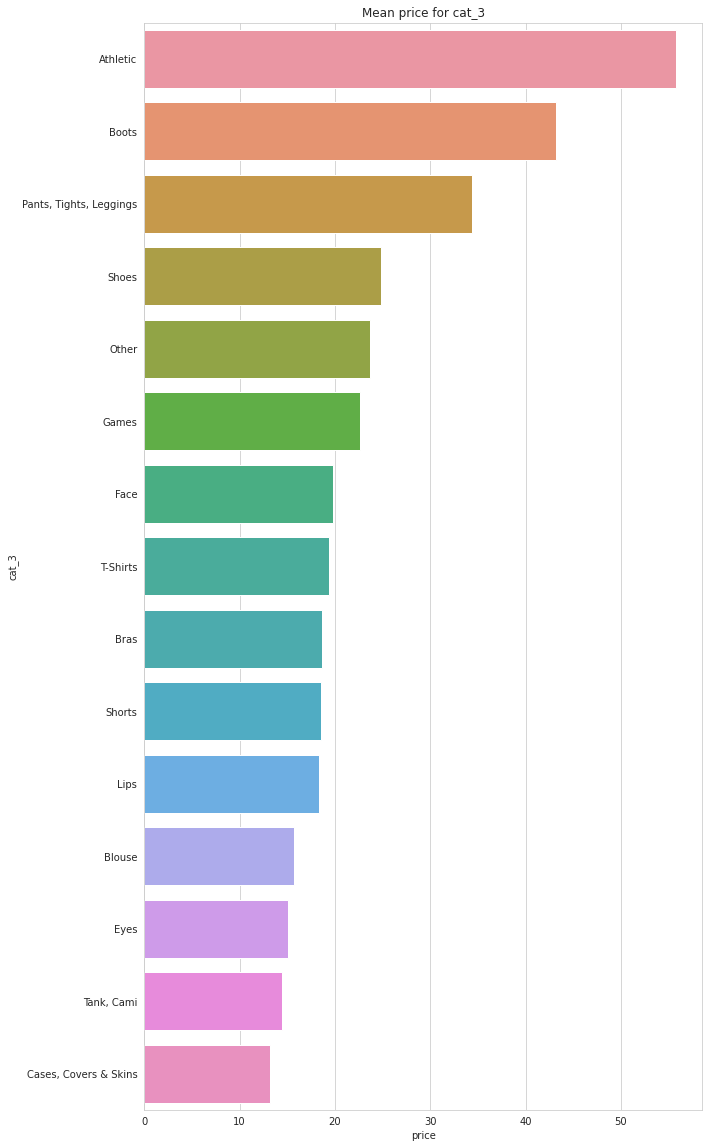

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(y='cat_3', x='price', data=df, order=df.sort_values('price', ascending=False).cat_3)
plt.title('Mean price for cat_3')
plt.show()

It can be seen that the highest price is for Atletic category of products, followed by boots, pants, tights and leggings.

# Creating features for test data

## Searching missing values of brand names in item name and item description.

In [ ]:
test_data['brand_name_mod'] = test_data['brand_name']

In [ ]:
brand_array = np.array(test_data['brand_name_mod'])
name_array = np.array(test_data['name'])
item_desc_array = np.array(test_data['item_description'])

In [ ]:
for i in tqdm(range(len(brand_array))):
  if brand_array[i] == 'missing':
    a = name_array[i].split()
    b = item_desc_array[i].split()
    c = set(a+b)

    for j in c:
      if j in brand_set:
        brand_array[i] = j

In [ ]:
test_data['brand_name_mod'] = brand_array

In [ ]:
test_data['brand_name'] = test_data['brand_name_mod']
test_data.drop('brand_name_mod', axis=1, inplace=True)

## Creating feature as a pricing category cheap, affordable and expensive based on the percentile value

In [ ]:
test_data['pricing_cat'] = test_data['brand_name'].apply(dict_fun)

## Creating feature as median of price for brand_name

In [ ]:
test_data['medain_brand_price'] = test_stg2_data['brand_name'].apply(dict_fun2)

In [ ]:
test_data.to_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/test_stg2_data.pkl')

In [ ]:
test_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/test_stg2_data.pkl')

In [ ]:
test_data.head()

,test_id,name,item_condition_id,brand_name,shipping,item_description,cat_1,cat_2,cat_3,pricing_cat,medain_brand_price
0,0,"Breast cancer ""I fight like a girl"" ring",1,missing,1,Size 7,Women,Jewelry,Rings,affordable,14.0
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,affordable,14.0
2,2,Coach bag,1,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,expensive,30.0
3,3,Floral Kimono,2,missing,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,affordable,14.0
4,4,Life after Death,3,missing,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,affordable,14.0


# Base line approach

Predicting the price of the product based on the median price of the brand of the product.

In [ ]:
test_data_submission = test_data[['test_id', 'medain_brand_price']]

In [ ]:
test_data_submission = test_data_submission.rename({'medain_brand_price':'price'}, axis=1)

In [ ]:
test_data_submission.head()

,test_id,price
0,0,14.0
1,1,14.0
2,2,30.0
3,3,14.0
4,4,14.0


# Preprocessing

In [ ]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
y_train = train_data['price'].values
X_train = train_data.drop(['price'], axis=1)

In [ ]:
y_tr = np.log1p(train_data["price"])

In [ ]:
from numpy import savez_compressed
savez_compressed('/content/drive/MyDrive/Colab Notebooks/Case_study_1/y_tr.npz', y_tr)

In [ ]:
X_test = test_data

In [ ]:
def preprocess(Input_text):

  """
  A function for filtering the text data like removing numbers, non english words, punctuations, converting to lower case, etc.
  """

  cleantext = ' '.join( [w for w in Input_text.split()[:60]] )
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', cleantext)
  cleantext = re.sub(r'\S*@\S*\s?', ' ', cleantext)
  cleantext = re.sub("[\(\[].*?[\)\]]", "", cleantext)
  cleantext = re.sub(r'\w+:\s?','',cleantext)
  cleantext = re.sub(r"\'m", " am", cleantext)
  cleantext = re.sub(r"n\'t", " not", cleantext)
  cleantext = re.sub(r"\'t", " not", cleantext)
  cleantext = re.sub(r"\'s", " is", cleantext)
  cleantext = re.sub(r"\'ve", " have", cleantext)
  cleantext = re.sub(r"\'re", " are", cleantext)
  cleantext = re.sub(r"\'ll", " will", cleantext)
  cleantext = re.sub(r"won't", "will not", cleantext)
  cleantext = re.sub(r"can\'t", "can not", cleantext)
  cleantext = re.sub(r"\'d", " would", cleantext)
  cleantext = re.sub(r'[0-9]+', '', cleantext)
  cleantext = cleantext.lower()
  cleantext = re.sub(r'[^a-zA-Z]+', ' ', cleantext)

  return cleantext

## Preprocessing all the text and categorical features of train and test data

In [ ]:
X_train['brand_name'] = X_train['brand_name'].apply(preprocess)
X_test['brand_name'] = X_test['brand_name'].apply(preprocess)

In [ ]:
X_train['name'] = X_train['name'].apply(preprocess)
X_test['name'] = X_test['name'].apply(preprocess)

In [ ]:
X_train['item_description'] = X_train['item_description'].apply(preprocess)
X_test['item_description'] = X_test['item_description'].apply(preprocess)

In [ ]:
X_train['cat_1'] = X_train['cat_1'].apply(preprocess)
X_train['cat_2'] = X_train['cat_2'].apply(preprocess)
X_train['cat_3'] = X_train['cat_3'].apply(preprocess)

X_test['cat_1'] = X_test['cat_1'].apply(preprocess)
X_test['cat_2'] = X_test['cat_2'].apply(preprocess)
X_test['cat_3'] = X_test['cat_3'].apply(preprocess)

In [ ]:
X_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_train.pkl')
X_test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_test.pkl')

In [ ]:
X_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_train.pkl')
X_test = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_test.pkl')

# Featurizing all categorical features using Label Encoder

## Brand name

In [ ]:
print("="*100)
print("After vectorizations")

brand_set1 = set(list(X_test['brand_name']) + list(X_train['brand_name']))
brand_lst1 = list(brand_set1)

label_encoder = LabelEncoder()

label_encoder.fit(brand_lst1)
X_train_brand_name_le = label_encoder.transform(X_train['brand_name'].values)
X_test_brand_name_le = label_encoder.transform(X_test['brand_name'].values)

X_train_brand_name_le = X_train_brand_name_le.reshape(-1,1)
X_test_brand_name_le = X_test_brand_name_le.reshape(-1,1)


print(X_train_brand_name_le.shape)
print(X_test_brand_name_le.shape)

## Shipping ID

In [ ]:
X_train_sh_id = np.array(X_train['shipping'])
X_test_sh_id = np.array(X_test['shipping'])

X_train_sh_id = X_train_sh_id.reshape(-1,1)
X_test_sh_id = X_test_sh_id.reshape(-1,1)

print(X_train_sh_id.shape)
print(X_test_sh_id.shape)

## Item condition ID

In [ ]:
X_train_ic_id = np.array(X_train['item_condition_id'])
X_test_ic_id = np.array(X_test['item_condition_id'])

X_train_ic_id = X_train_ic_id.reshape(-1,1)
X_test_ic_id = X_test_ic_id.reshape(-1,1)

print(X_train_ic_id.shape)
print(X_test_ic_id.shape)

## Median brand price

In [ ]:
X_train_mbp = np.array(X_train['medain_brand_price'])
X_test_mbp = np.array(X_test['medain_brand_price'])

X_train_mbp = X_train_mbp.reshape(-1,1)
X_test_mbp = X_test_mbp.reshape(-1,1)

print(X_train_mbp.shape)
print(X_test_mbp.shape)

## Category 1

In [ ]:
print("="*100)
print("After vectorizations")

label_encoder = LabelEncoder()

label_encoder.fit(X_train['cat_1'].values)
X_train_cat_1_le = label_encoder.transform(X_train['cat_1'].values)
X_test_cat_1_le = label_encoder.transform(X_test['cat_1'].values)

X_train_cat_1_le = X_train_cat_1_le.reshape(-1,1)
X_test_cat_1_le = X_test_cat_1_le.reshape(-1,1)

print(X_train_cat_1_le.shape)
print(X_test_cat_1_le.shape)

## Category 2

In [ ]:
print("="*100)
print("After vectorizations")

label_encoder = LabelEncoder()

label_encoder.fit(X_train['cat_2'].values)
X_train_cat_2_le = label_encoder.transform(X_train['cat_2'].values)
X_test_cat_2_le = label_encoder.transform(X_test['cat_2'].values)

X_train_cat_2_le = X_train_cat_2_le.reshape(-1,1)
X_test_cat_2_le = X_test_cat_2_le.reshape(-1,1)

print(X_train_cat_2_le.shape)
print(X_test_cat_2_le.shape)

## Category 3

In [ ]:
print("="*100)
print("After vectorizations")

cat3_set1 = set(list(X_test['cat_3']) + list(X_train['cat_3']))
cat3_lst1 = list(cat3_set1)

label_encoder = LabelEncoder()

label_encoder.fit(cat3_lst1)
X_train_cat_3_le = label_encoder.transform(X_train['cat_3'].values)
X_test_cat_3_le = label_encoder.transform(X_test['cat_3'].values)

X_train_cat_3_le = X_train_cat_3_le.reshape(-1,1)
X_test_cat_3_le = X_test_cat_3_le.reshape(-1,1)

print(X_train_cat_3_le.shape)
print(X_test_cat_3_le.shape)

## Pricing category

In [ ]:
print("="*100)
print("After vectorizations")

label_encoder = LabelEncoder()

label_encoder.fit(X_train['pricing_cat'].values)
X_train_pricing_cat_le = label_encoder.transform(X_train['pricing_cat'].values)
X_test_pricing_cat_le = label_encoder.transform(X_test['pricing_cat'].values)

X_train_pricing_cat_le = X_train_pricing_cat_le.reshape(-1,1)
X_test_pricing_cat_le = X_test_pricing_cat_le.reshape(-1,1)

print(X_train_pricing_cat_le.shape)
print(X_test_pricing_cat_le.shape)

# Featurizing all text features using TfidfVectorizer

## Name

In [ ]:
print("="*100)
print("After vectorizations")

vectorizer1 = TfidfVectorizer(max_features=1000)
vectorizer1.fit(X_train['name'].values)

X_train_name_tfidf = vectorizer1.transform(X_train['name'].values)
X_test_name_tfidf = vectorizer1.transform(X_test['name'].values)

print(X_train_name_tfidf.shape)
print(X_test_name_tfidf.shape)

## Item description

In [ ]:
print("="*100)
print("After vectorizations")

vectorizer1 = TfidfVectorizer(min_df=10, max_features=5000) #ngram_range=(1,4)
vectorizer1.fit(X_train['item_description'].values)

X_train_id_tfidf = vectorizer1.transform(X_train['item_description'].values)
X_test_id_tfidf = vectorizer1.transform(X_test['item_description'].values)

print(X_train_id_tfidf.shape)
print(X_test_id_tfidf.shape)

## Concatenating all features

In [ ]:
from scipy.sparse import hstack

X_tr = hstack((X_train_brand_name_le, X_train_sh_id, X_train_ic_id, X_train_mbp, X_train_cat_1_le, X_train_cat_2_le, X_train_cat_3_le, X_train_pricing_cat_le, X_train_name_tfidf, X_train_id_tfidf)).tocsr()
X_te = hstack((X_test_brand_name_le, X_test_sh_id, X_test_ic_id, X_test_mbp, X_test_cat_1_le, X_test_cat_2_le, X_test_cat_3_le, X_test_pricing_cat_le, X_test_name_tfidf, X_test_id_tfidf)).tocsr()

In [ ]:
from scipy import sparse

sparse.save_npz("/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_tr.npz", X_tr)
sparse.save_npz("/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_te.npz", X_te)

In [ ]:
X_tr1 = sparse.load_npz("/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_tr.npz")
X_tr1.shape

(1481661, 6008)

In [ ]:
X_te1 = sparse.load_npz("/content/drive/MyDrive/Colab Notebooks/Case_study_1/X_te.npz")
X_te1.shape

(3460725, 6008)

## Training models

In [ ]:
from numpy import load
dict_data = load('/content/drive/MyDrive/Colab Notebooks/Case_study_1/y_tr.npz')

In [ ]:
y_tr1 = dict_data['arr_0']
y_tr1.shape

(1481661,)

# ML Model

## Custom Random forest

In [ ]:
def generating_samples(input_data, target_data):

  """
  A function for creating random samples of size 1/10 th of the training data with column sampling.
  """
  a = np.arange(0, input_data.shape[0])
  b = np.random.choice(a, size=148166, replace=False)
  b1 = list(b)

  d = np.arange(0, input_data.shape[1])
  e = np.random.randint(2000, input_data.shape[1]+1)
  f = np.random.choice(d, size=e, replace=False)
  f1 = list(f)

  # Sample data
  sample_data = input_data[b1][:, f1]
  target_of_sample_data = target_data[b1]

  return sample_data, target_of_sample_data, b1, f1

## Creating 30 random samples from the above function

In [ ]:
list_input_data =[]
list_output_data =[]
list_selected_row= []
list_selected_columns=[]

for i in tqdm(range(0, 30)):
  a, b, c, d = generating_samples(X_tr1, y_tr1)
  list_input_data.append(a)
  list_output_data.append(b)
  list_selected_row.append(c)
  list_selected_columns.append(d)

100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


## Applying Decision tree regressor on each of the sample

In [ ]:
from sklearn.tree import DecisionTreeRegressor

list_of_all_models = list()
for i in tqdm(range(0, 30)):
  decision_tree = DecisionTreeRegressor()
  decision_tree.fit(list_input_data[i], list_output_data[i])
  list_of_all_models.append(decision_tree)

100%|██████████| 30/30 [1:25:43<00:00, 171.45s/it]


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Case_study_1/models_lst3.txt", "wb") as fp:
  pickle.dump(list_of_all_models, fp)

## Passing each data point from est data into 30 DT models and calculating the median of the prediction

In [ ]:
list_of_y_predicted = list()
for i in tqdm(range(0, 30)):
  y_pred = list_of_all_models[i].predict(X_te1[:, list_selected_columns[i]])
  list_of_y_predicted.append(y_pred)

100%|██████████| 30/30 [02:20<00:00,  4.70s/it]


In [ ]:
array_of_y_predicted = np.array(list_of_y_predicted)
y_test_pred = np.median(array_of_y_predicted, axis=0)

In [ ]:
test_data['price'] = y_test_pred

In [ ]:
test_data.head()

,test_id,name,item_condition_id,brand_name,shipping,item_description,cat_1,cat_2,cat_3,pricing_cat,medain_brand_price,price
0,0,"Breast cancer ""I fight like a girl"" ring",1,missing,1,Size 7,Women,Jewelry,Rings,affordable,14.0,2.530031
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,affordable,14.0,2.249905
2,2,Coach bag,1,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,expensive,30.0,3.583133
3,3,Floral Kimono,2,missing,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,affordable,14.0,2.673554
4,4,Life after Death,3,missing,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,affordable,14.0,2.302585


## Preparing the file for submission

In [ ]:
te_sub_crf3 = test_data[['test_id', 'price']]

In [ ]:
te_sub_crf3.head()

,test_id,price
0,0,2.530031
1,1,2.249905
2,2,3.583133
3,3,2.673554
4,4,2.302585


In [ ]:
te_sub_crf3['price'] = np.expm1(te_sub_crf3['price'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
te_sub_crf3.to_csv('/content/drive/MyDrive/Colab Notebooks/Case_study_1/te_sub_crf3.csv', index=False)

In [ ]:
te_sub_crf3.head()

,test_id,price
0,0,11.553892
1,1,8.486833
2,2,34.986108
3,3,13.491377
4,4,9.000000
